# Text classification on Amazon Reviews Dataset using Scikit-Learn Python Library

In [1]:
# for Python 2: use print only as a function
%matplotlib inline
import matplotlib.pyplot as plt
from __future__ import print_function
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier 
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import cross_val_score, cross_val_predict
from sklearn.pipeline import Pipeline
import ast
import os, csv, gc

import pandas as pd
import random
from sklearn import svm

In [2]:
df = pd.read_csv('cd3.csv')
df.shape

(103149, 5)

In [3]:
df.head()

,review/text,product/categories,root_class,length,root_class2
0,"Not many ""indie"" bands get to have their own D...","['CDs & Vinyl', 'Alternative Rock', 'Indie & L...",CDs & Vinyl,507,Alternative Rock
1,"I had a Death Cab for Cutie phase, so this DVD...","['CDs & Vinyl', 'Alternative Rock', 'Indie & L...",CDs & Vinyl,241,Alternative Rock
2,Every rock band needs to make at least one tou...,"['CDs & Vinyl', 'Alternative Rock', 'Indie & L...",CDs & Vinyl,1221,Alternative Rock
3,I saw this last night on the Encore channel an...,"['CDs & Vinyl', 'Alternative Rock', 'Indie & L...",CDs & Vinyl,1880,Alternative Rock
4,i love the dvd the only thing that irkes me is...,"['CDs & Vinyl', 'Alternative Rock', 'Indie & L...",CDs & Vinyl,458,Alternative Rock


In [4]:
# Η συνάρτηση ranDF επιστρέφει δέχεται ως όρισματα ένα 
# dataframe (df), ένα string (col) που αντιπροσωπεύει το
# όνομα μίας στήλης του df και δύο integers (a και b) που
# αντιπροσωπεύουν άνω κάι κάτω όρια στο πλήθος των instances.
# Επιστρέφει ένα dataframe, αντίγραφο αυτού της εισόδου με
# την διαφορά ότι το πλήθος των instances του νέου dataframe
# θα κυμαίνεται μεταξύ των τιμών του a και b.
def ranDF(df, col, a, b):
    # Η label_list αποθηκεύει μια λίστα με τα labels του dataset
    label_list = df[col].value_counts().to_dict().keys()
    # H rows αποθηκεύει μια λίστα από τυχαία indexes των instances του
    # dataset που ανήκουν στο πρώτο label. Το πλήθος των indexes κυμαίνεται 
    # μεταξύ των τιμών των μεταβλητών a και b για λόγους διακύμανσης των πλήθων τους
    rows = np.random.choice(df[df[col] == label_list[0]].index.values,
                       random.randint(a, b))
    # Δημιουργείται ένα dataframe από τα instances των παραπάνω indexes
    sampled_df = df.ix[rows]
    # Το παραπάνω dataframe εμπλουτίζεται με instances από όλα τα labels με παρόμοιο πλήθος σε κάθε label
    for f in label_list[1:]:
        rows = np.random.choice(df[df[col] == f].index.values, 
                               random.randint(a, b))
        sampled_df = sampled_df.append(df.ix[rows], ignore_index=True)
    return sampled_df

In [5]:
# Πλήθος instances ανά label
df.root_class2.value_counts()

Pop                   27756
Rock                  13204
World Music           12008
Alternative Rock      11519
Classic Rock           8210
Jazz                   4201
Special Interest       3762
Country                3713
Classical              2784
Christian              2603
Blues                  2445
Metal                  2261
Children's Music       2133
R&B                    1666
New Age                1526
Folk                   1176
Dance & Electronic     1155
Rap & Hip-Hop          1027
Name: root_class2, dtype: int64

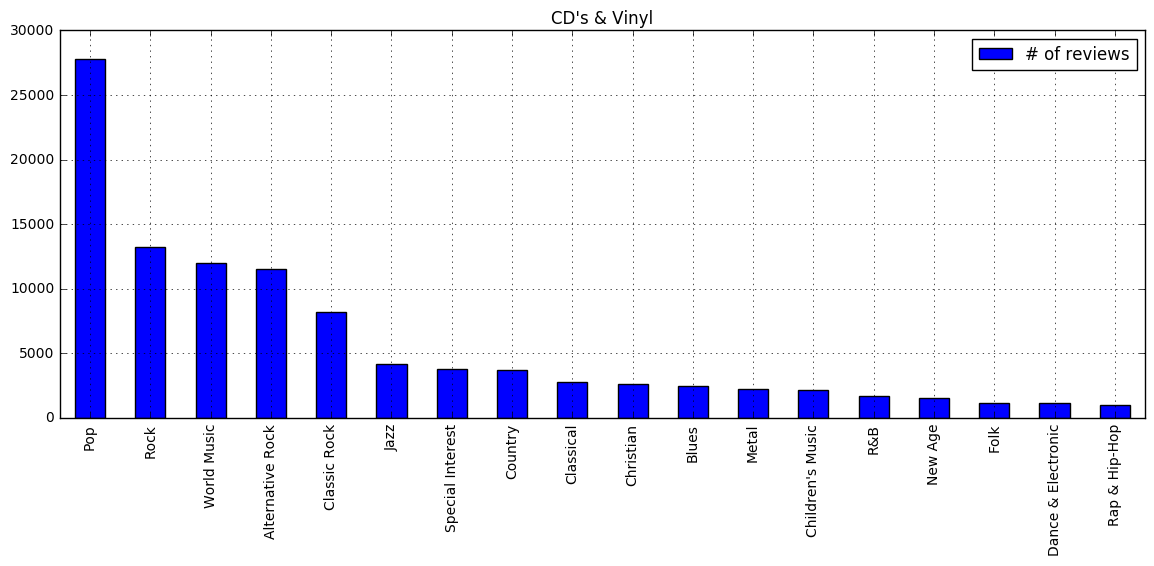

In [6]:
df.root_class2.value_counts().plot(kind='bar', ax=None, figsize=(14,5), use_index=True, title='CD\'s & Vinyl' , grid=True, legend=True, style=None, logy=False, label='# of reviews')

In [7]:
# Δημιουργία του dataset (dataframe) στο οποίο οριοθετείται το πλήθος των 
# reviews για κάθε label μεταξύ 970 και 1027 instances
df = ranDF(df, 'root_class2', 970, 1027)

In [8]:
# Πλήθος του τελικού
df.shape

(17960, 5)

In [10]:
# Πληροφορίες για το μήκος των reviews
df.length.describe()

count    17960.000000
mean       717.957795
std        829.015221
min         25.000000
25%        237.000000
50%        460.000000
75%        890.000000
max      17971.000000
Name: length, dtype: float64

In [11]:
# Κατανομή των reviews ανά πλήρη κατηγοριοποίηση (όχι μόνο στο root label)
df['product/categories'].value_counts()

['CDs & Vinyl', 'Special Interest', 'Instructional']                                 996
['CDs & Vinyl', 'Christian', 'Pop & Contemporary']                                   964
['CDs & Vinyl', "Children's Music", 'Disney']                                        904
['CDs & Vinyl', 'Classical', 'Symphonies']                                           862
['CDs & Vinyl', 'Classic Rock', 'Album-Oriented Rock (AOR)']                         686
['CDs & Vinyl', 'World Music', 'Europe', 'British Isles', 'Britain']                 673
['CDs & Vinyl', 'Folk', 'Contemporary Folk']                                         669
['CDs & Vinyl', 'Rock', 'Progressive', 'Progressive Rock']                           633
['CDs & Vinyl', 'New Age', 'Meditation']                                             600
['CDs & Vinyl', 'Dance & Electronic', 'Electronica']                                 586
['CDs & Vinyl', 'Rap & Hip-Hop', 'Pop Rap']                                          502
['CDs & Vinyl', 'R&B'

In [12]:
# Πλήθος instances ανά label μετά την οποιόμορφη κατανομή του πλήθος αυτών
distr = df.root_class2.value_counts()
distr

Alternative Rock      1014
New Age               1012
Classical             1012
Pop                   1008
Dance & Electronic    1006
Rap & Hip-Hop         1004
Christian             1002
Classic Rock          1002
Folk                  1001
Children's Music      1000
Special Interest       999
Rock                   994
Country                994
Jazz                   992
Metal                  991
World Music            982
R&B                    975
Blues                  972
Name: root_class2, dtype: int64

In [13]:
# Αρίθμηση των label (id's) 
tempDict = {}
for item, value in enumerate(distr.to_dict().keys()):
    tempDict[value] = item
tempDict

{'Alternative Rock': 0,
 'Blues': 15,
 "Children's Music": 5,
 'Christian': 1,
 'Classic Rock': 17,
 'Classical': 2,
 'Country': 4,
 'Dance & Electronic': 11,
 'Folk': 16,
 'Jazz': 6,
 'Metal': 7,
 'New Age': 10,
 'Pop': 9,
 'R&B': 3,
 'Rap & Hip-Hop': 12,
 'Rock': 14,
 'Special Interest': 8,
 'World Music': 13}

In [14]:
# Προσθήκη νέας στήλης real_category_num με το id του label που ανήκει το κάθε instance
df['real_category_num'] = df.root_class2.map(tempDict)

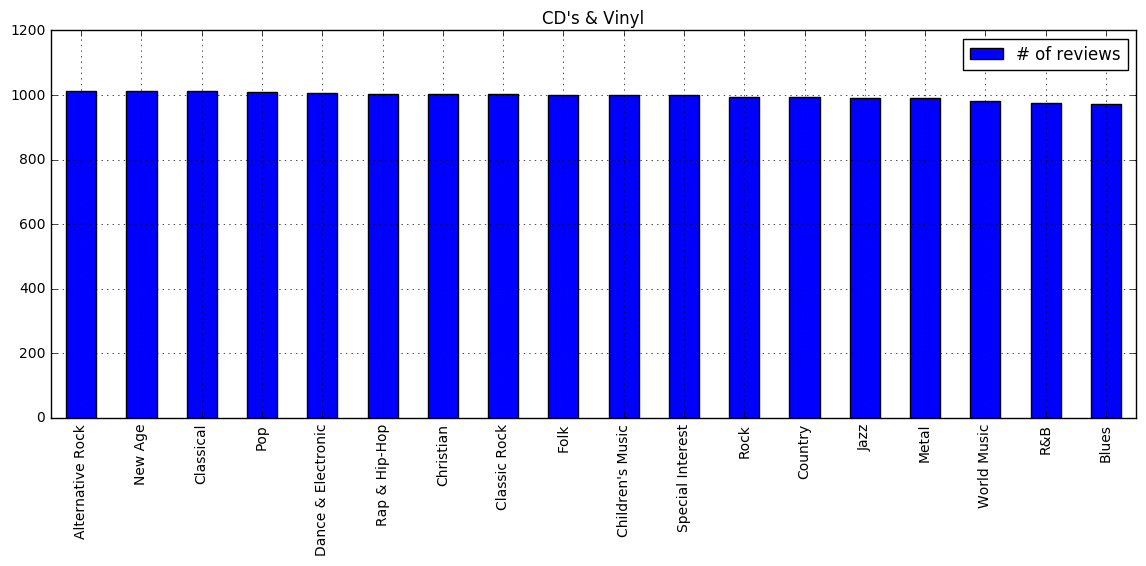

In [15]:
# Διάγραμμα με το πλήθος των reviews ανά label
distr.plot(kind='bar', ax=None, figsize=(14,5), use_index=True, title='CD\'s & Vinyl' , grid=True, legend=True, style=None, logy=False, label='# of reviews')

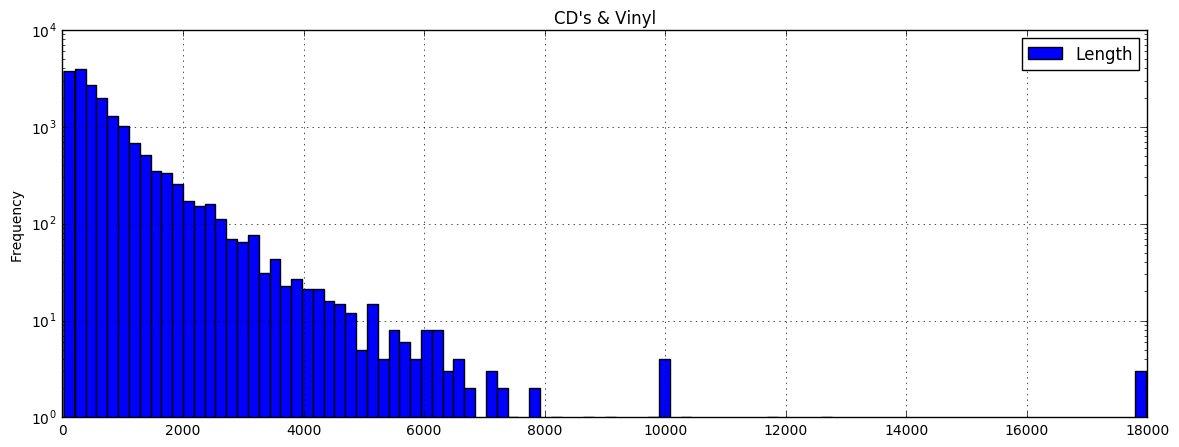

In [113]:
# Κατανομή των reviews σχετικά με το μήκος τους
df.length.plot(bins=100, kind='hist', ax=None, figsize=(14,5), use_index=True, title='CD\'s & Vinyl' , grid=True, legend=True, style=None, logy=True, label='Length')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f66667d9410>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f6662707c50>]], dtype=object)

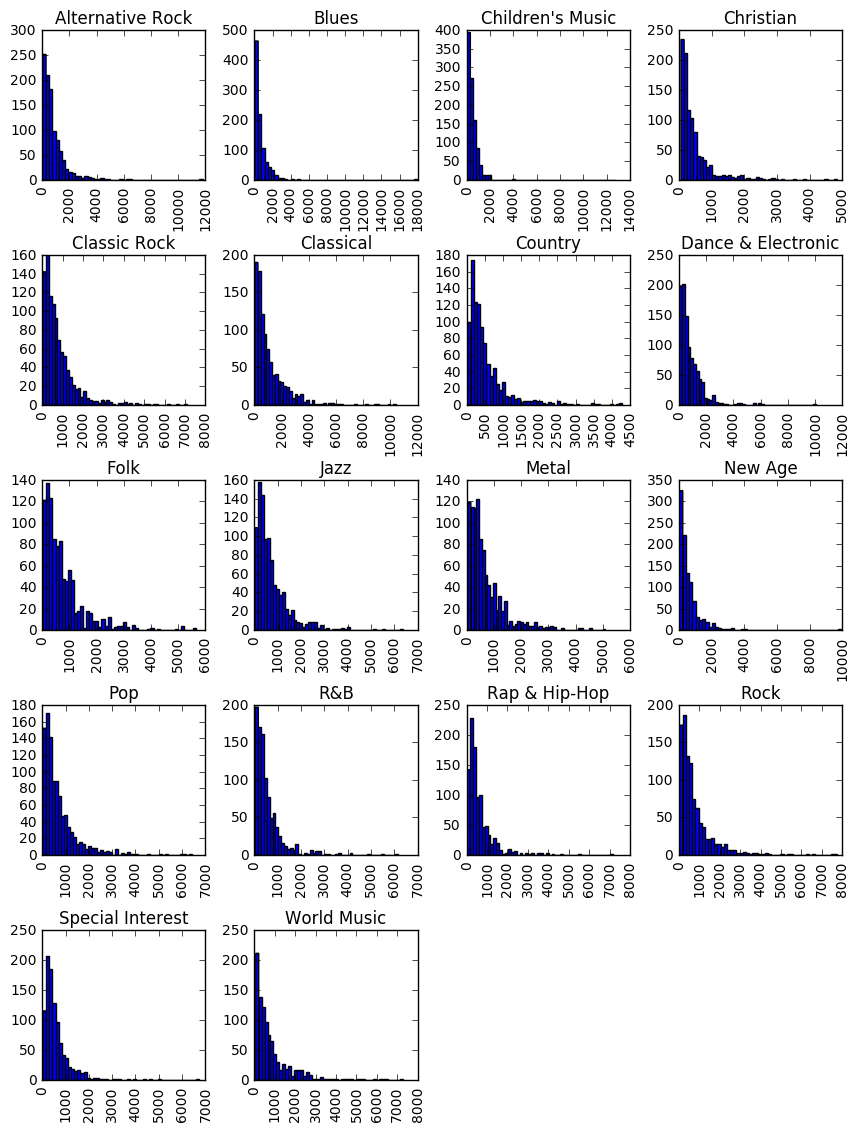

In [17]:
df.hist(column='length', by='root_class2', bins=50, figsize=(10, 14))

In [18]:
# how to define X and y for use with COUNTVECTORIZER
X = df['review/text']
y = df.real_category_num

In [19]:
print(X.shape)
print(y.shape)

(17960,)
(17960,)


In [20]:
# split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(14368,)
(3592,)
(14368,)
(3592,)


In [21]:
# instantiate CountVectorizer (with the default parameters)
vect = CountVectorizer(max_df=0.7, min_df=2, stop_words='english', ngram_range=(1, 3))

In [22]:
# learn training data vocabulary, then use it to create a document-term matrix
try:
    X_train_dtm = vect.fit_transform(X_train)
except UnicodeDecodeError as inst:
    print (type(inst))
    print (inst)

In [23]:
X_train_dtm

<14368x290955 sparse matrix of type '<type 'numpy.int64'>'
	with 1522129 stored elements in Compressed Sparse Row format>

In [24]:
# transform testing data (using fitted vocabulary) into a document-term matrix
X_test_dtm = vect.transform(X_test)
X_test_dtm

<3592x290955 sparse matrix of type '<type 'numpy.int64'>'
	with 287299 stored elements in Compressed Sparse Row format>

In [25]:
models = {'NB':[],'RF':[],'LR':[],'KNN':[],'SVM':[]}

# Naive Bayes model

In [26]:
# instantiate a Multinomial Naive Bayes model
nb = MultinomialNB()

In [27]:
# train the model using X_train_dtm (timing it with an IPython "magic command")
%time nb.fit(X_train_dtm, y_train)

CPU times: user 320 ms, sys: 440 ms, total: 760 ms
Wall time: 762 ms


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [28]:
# make class predictions for X_test_dtm
y_pred_class = nb.predict(X_test_dtm)

In [29]:
# calculate accuracy of class predictions
res = metrics.accuracy_score(y_test, y_pred_class)
models['NB'].append(res)
print("Accuracy: %0.2f %%" % (res*100))

Accuracy: 68.26 %


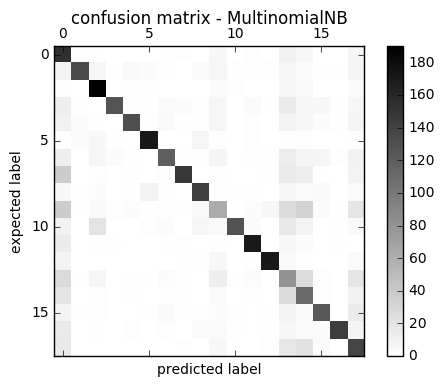

In [30]:
plt.matshow(metrics.confusion_matrix(y_test, y_pred_class),
            cmap=plt.cm.binary, interpolation='nearest', fignum=0)
plt.title('confusion matrix - ' + str(str(nb)[0:str(nb).find("(")]))
plt.colorbar()
plt.ylabel('expected label')
plt.xlabel('predicted label')

In [31]:
print (classification_report(y_test, y_pred_class))

             precision    recall  f1-score   support

          0       0.38      0.81      0.51       192
          1       0.91      0.68      0.78       198
          2       0.74      0.89      0.81       214
          3       0.94      0.64      0.76       199
          4       0.88      0.68      0.77       192
          5       0.89      0.87      0.88       196
          6       0.78      0.61      0.69       197
          7       0.89      0.64      0.74       231
          8       0.81      0.76      0.78       189
          9       0.43      0.29      0.35       214
         10       0.93      0.61      0.74       211
         11       0.88      0.85      0.86       201
         12       0.92      0.85      0.88       202
         13       0.29      0.43      0.34       189
         14       0.41      0.61      0.49       182
         15       0.78      0.69      0.73       180
         16       0.95      0.73      0.83       196
         17       0.50      0.67      0.57   

## 10-Fold Cross Validation

In [32]:
pipeline = Pipeline([
    ('bow', CountVectorizer(max_df=0.7, min_df=2, stop_words='english', ngram_range=(1, 3))),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', nb),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

In [33]:
scores = cross_val_score(pipeline,  # steps to convert raw messages into models
                         X,  # training data
                         y,  # training labels
                         cv=10,  # split data randomly into 10 parts: 9 for training, 1 for scoring
                         scoring='accuracy',  # which scoring metric?
                         n_jobs=-1,  # -1 = use all cores = faster
                         )
print(scores)

[ 0.71721085  0.70304709  0.7163515   0.72024472  0.72575251  0.70886782
  0.71149554  0.71205357  0.71356784  0.7150838 ]


In [34]:
res = scores.mean()
models['NB'].append(res)
print("Accuracy: %0.2f %% (+/- %0.2f %%)" % (scores.mean()*100, scores.std() * 2 * 100))

Accuracy: 71.44 % (+/- 1.18 %)


# Logistic regression model


In [35]:
# instantiate a logistic regression model
logreg = LogisticRegression()

In [36]:
# train the model using X_train_dtm
%time logreg.fit(X_train_dtm, y_train)

CPU times: user 4min 45s, sys: 5.76 s, total: 4min 51s
Wall time: 2min 29s


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [37]:
# make class predictions for X_test_dtm
y_pred_class = logreg.predict(X_test_dtm)

In [38]:
# calculate accuracy
res = metrics.accuracy_score(y_test, y_pred_class)
models['LR'].append(res)
print("Accuracy: %0.2f %%" % (res*100))

Accuracy: 71.58 %


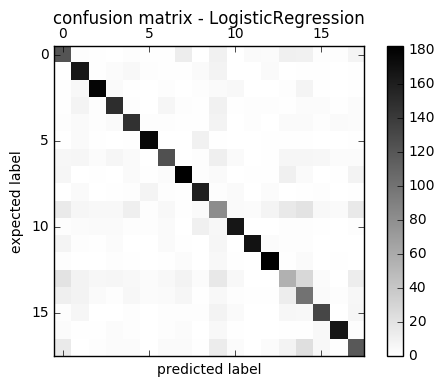

In [39]:
plt.matshow(metrics.confusion_matrix(y_test, y_pred_class),
            cmap=plt.cm.binary, interpolation='nearest', fignum=0)
plt.title('confusion matrix - ' + str(str(logreg)[0:str(logreg).find("(")]))
plt.colorbar()
plt.ylabel('expected label')
plt.xlabel('predicted label')

In [40]:
print (classification_report(y_test, y_pred_class))

             precision    recall  f1-score   support

          0       0.56      0.64      0.60       192
          1       0.70      0.83      0.76       198
          2       0.84      0.83      0.84       214
          3       0.76      0.75      0.76       199
          4       0.73      0.76      0.74       192
          5       0.88      0.89      0.89       196
          6       0.72      0.63      0.67       197
          7       0.79      0.79      0.79       231
          8       0.78      0.84      0.81       189
          9       0.39      0.38      0.39       214
         10       0.83      0.79      0.81       211
         11       0.93      0.84      0.88       201
         12       0.86      0.90      0.88       202
         13       0.39      0.30      0.34       189
         14       0.45      0.55      0.49       182
         15       0.77      0.73      0.75       180
         16       0.90      0.85      0.87       196
         17       0.61      0.57      0.59   

## 10-Fold Cross Validation

In [41]:
pipeline = Pipeline([
    ('bow', CountVectorizer(max_df=0.7, min_df=2, stop_words='english', ngram_range=(1, 3))),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', logreg),  # train on TF-IDF vectors w/ Logistic Regression classifier
])

In [42]:
scores = cross_val_score(pipeline,  # steps to convert raw messages into models
                         X,  # training data
                         y,  # training labels
                         cv=10,  # split data randomly into 10 parts: 9 for training, 1 for scoring
                         scoring='accuracy',  # which scoring metric?
                         n_jobs=-1,  # -1 = use all cores = faster
                         )
print(scores)

[ 0.73990039  0.71523546  0.7246941   0.72858732  0.7335563   0.72169548
  0.71819196  0.72209821  0.71356784  0.73631285]


In [43]:
res = scores.mean()
models['LR'].append(res)
print("Accuracy: %0.2f %% (+/- %0.2f %%)" % (scores.mean()*100, scores.std() * 2 * 100))

Accuracy: 72.54 % (+/- 1.70 %)


# Random Forest model

In [44]:
rf = RandomForestClassifier()
rf.fit(X_train_dtm, y_train)
y_pred_class = rf.predict(X_test_dtm)

In [45]:
# calculate accuracy of class predictions
res = metrics.accuracy_score(y_test, y_pred_class)
models['RF'].append(res)
print("Accuracy: %0.2f %%" % (res*100))

Accuracy: 59.44 %


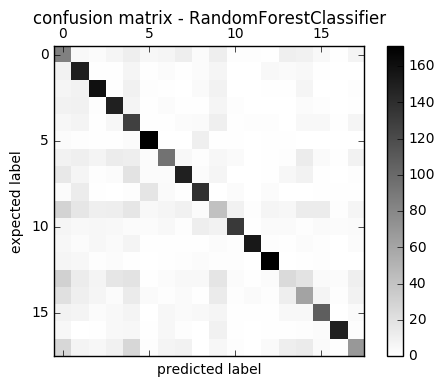

In [46]:
plt.matshow(metrics.confusion_matrix(y_test, y_pred_class), cmap=plt.cm.binary, interpolation='nearest', fignum=0)
plt.title('confusion matrix - ' + str(str(rf)[0:str(rf).find("(")]))
plt.colorbar()
plt.ylabel('expected label')
plt.xlabel('predicted label')

In [47]:
print (classification_report(y_test, y_pred_class))

             precision    recall  f1-score   support

          0       0.29      0.44      0.35       192
          1       0.52      0.76      0.62       198
          2       0.70      0.75      0.72       214
          3       0.61      0.75      0.67       199
          4       0.42      0.67      0.52       192
          5       0.77      0.87      0.82       196
          6       0.61      0.48      0.53       197
          7       0.71      0.65      0.67       231
          8       0.69      0.73      0.71       189
          9       0.25      0.20      0.22       214
         10       0.79      0.63      0.70       211
         11       0.92      0.77      0.84       201
         12       0.81      0.84      0.83       202
         13       0.27      0.13      0.18       189
         14       0.36      0.34      0.35       182
         15       0.65      0.60      0.62       180
         16       0.91      0.76      0.83       196
         17       0.50      0.33      0.40   

## 10-Fold Cross Validation

In [48]:
pipeline = Pipeline([
    ('bow', CountVectorizer(max_df=0.7, min_df=2, stop_words='english', ngram_range=(1, 3))),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', rf),  # train on TF-IDF vectors w/ Random forest classifier
])

In [49]:
scores = cross_val_score(pipeline,  # steps to convert raw messages into models
                         X,  # training data
                         y,  # training labels
                         cv=10,  # split data randomly into 10 parts: 9 for training, 1 for scoring
                         scoring='accuracy',  # which scoring metric?
                         n_jobs=-1,  # -1 = use all cores = faster
                         )
print(scores)

[ 0.60044272  0.5700831   0.5945495   0.60122358  0.61538462  0.59286113
  0.59542411  0.59207589  0.59073143  0.59106145]


In [50]:
res = scores.mean()
models['RF'].append(res)
print("Accuracy: %0.2f %% (+/- %0.2f %%)" % (scores.mean()*100, scores.std() * 2 * 100))

Accuracy: 59.44 % (+/- 2.14 %)


# KNN model

In [51]:
# try K=1, record testing accuracy
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train_dtm, y_train)
y_pred_class = knn.predict(X_test_dtm)

In [52]:
# calculate accuracy of class predictions
res = metrics.accuracy_score(y_test, y_pred_class)
models['KNN'].append(res)
print("Accuracy: %0.2f %%" % (res * 100))

Accuracy: 42.37 %


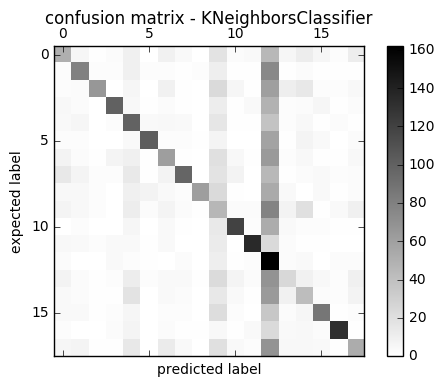

In [53]:
plt.matshow(metrics.confusion_matrix(y_test, y_pred_class), cmap=plt.cm.binary, interpolation='nearest', fignum=0)
plt.title('confusion matrix - ' + str(str(knn)[0:str(knn).find("(")]))
plt.colorbar()
plt.ylabel('expected label')
plt.xlabel('predicted label')

In [54]:
print (classification_report(y_test, y_pred_class))

             precision    recall  f1-score   support

          0       0.38      0.27      0.31       192
          1       0.56      0.40      0.47       198
          2       0.80      0.31      0.45       214
          3       0.75      0.50      0.60       199
          4       0.40      0.52      0.45       192
          5       0.81      0.53      0.64       196
          6       0.43      0.31      0.36       197
          7       0.73      0.42      0.54       231
          8       0.91      0.33      0.48       189
          9       0.14      0.21      0.17       214
         10       0.71      0.56      0.63       211
         11       0.82      0.67      0.74       201
         12       0.15      0.80      0.26       202
         13       0.27      0.13      0.18       189
         14       0.29      0.23      0.26       182
         15       0.64      0.48      0.55       180
         16       0.83      0.67      0.74       196
         17       0.43      0.25      0.32   

## 10-Fold Cross Validation

In [55]:
pipeline = Pipeline([
    ('bow', CountVectorizer(max_df=0.7, min_df=2, stop_words='english', ngram_range=(1, 3))),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', knn),  # train on TF-IDF vectors w/ ΚΝΝ classifier
])

In [56]:
scores = cross_val_score(pipeline,  # steps to convert raw messages into models
                         X,  # training data
                         y,  # training labels
                         cv=10,  # split data randomly into 10 parts: 9 for training, 1 for scoring
                         scoring='accuracy',  # which scoring metric?
                         n_jobs=-1,  # -1 = use all cores = faster
                         )
print(scores)

[ 0.41505257  0.39224377  0.37931034  0.40378198  0.42307692  0.41215839
  0.40513393  0.40290179  0.41708543  0.40614525]


In [57]:
res = scores.mean()
models['KNN'].append(res)
print("Accuracy: %0.2f %% (+/- %0.2f %%)" % (scores.mean() * 100, scores.std() * 2 * 100))

Accuracy: 40.57 % (+/- 2.41 %)


# SVM model

In [58]:
svm_clf = svm.SVC(kernel='linear')
# train the model using X_train_dtm
%time svm_clf.fit(X_train_dtm, y_train)

CPU times: user 4min 34s, sys: 224 ms, total: 4min 34s
Wall time: 4min 35s


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [59]:
# make class predictions for X_test_dtm
y_pred_class = svm_clf.predict(X_test_dtm)

In [60]:
# calculate accuracy
res = metrics.accuracy_score(y_test, y_pred_class)
models['SVM'].append(res)
print("Accuracy: %0.2f %%" % (res * 100))

Accuracy: 65.59 %


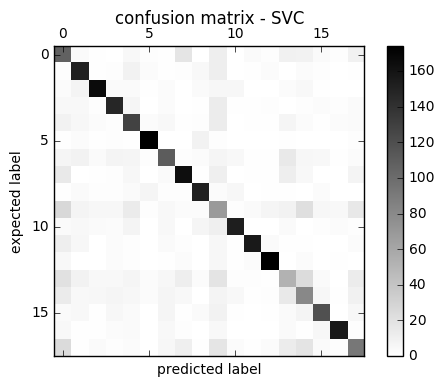

In [61]:
plt.matshow(metrics.confusion_matrix(y_test, y_pred_class), cmap=plt.cm.binary, interpolation='nearest', fignum=0)
plt.title('confusion matrix - ' + str(str(svm_clf)[0:str(svm_clf).find("(")]))
plt.colorbar()
plt.ylabel('expected label')
plt.xlabel('predicted label')

In [62]:
print (classification_report(y_test, y_pred_class))

             precision    recall  f1-score   support

          0       0.40      0.56      0.47       192
          1       0.66      0.76      0.71       198
          2       0.80      0.78      0.79       214
          3       0.71      0.74      0.73       199
          4       0.58      0.67      0.62       192
          5       0.87      0.89      0.88       196
          6       0.63      0.56      0.60       197
          7       0.72      0.71      0.71       231
          8       0.78      0.80      0.79       189
          9       0.30      0.32      0.31       214
         10       0.82      0.73      0.77       211
         11       0.89      0.78      0.83       201
         12       0.86      0.86      0.86       202
         13       0.35      0.28      0.31       189
         14       0.42      0.45      0.43       182
         15       0.72      0.66      0.69       180
         16       0.89      0.80      0.84       196
         17       0.53      0.44      0.48   

## 10-Fold Cross Validation

In [63]:
pipeline = Pipeline([
    ('bow', CountVectorizer(max_df=0.7, min_df=2, stop_words='english', ngram_range=(1, 3))),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', svm_clf),  # train on TF-IDF vectors w/ SVM classifier
])

In [64]:
scores = cross_val_score(pipeline,  # steps to convert raw messages into models
                         X,  # training data
                         y,  # training labels
                         cv=10,  # split data randomly into 10 parts: 9 for training, 1 for scoring
                         scoring='accuracy',  # which scoring metric?
                         n_jobs=-1,  # -1 = use all cores = faster
                         )
print(scores)

[ 0.74377421  0.71966759  0.74860957  0.73414905  0.74080268  0.73508087
  0.73158482  0.73381696  0.72473479  0.74134078]


In [65]:
res = scores.mean()
models['SVM'].append(res)
print("Accuracy: %0.2f %% (+/- %0.2f %%)" % (scores.mean() * 100, scores.std() * 2 * 100))

Accuracy: 73.54 % (+/- 1.66 %)


In [66]:
modelsTT = {}
for i in models.keys():
    modelsTT[i] = models[i][0]
    
modelsCV = {}
for i in models.keys():
    modelsCV[i] = models[i][1]

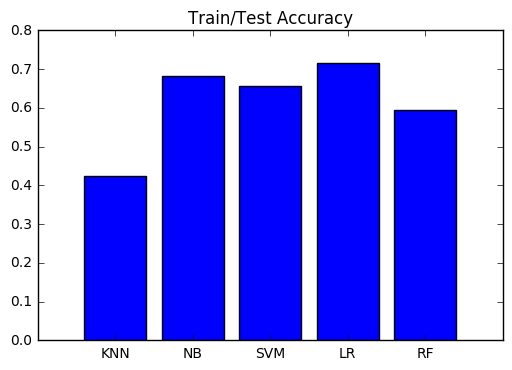

In [67]:
plt.title('Train/Test Accuracy')
plt.bar(range(len(modelsTT)), modelsTT.values(), align='center')
plt.xticks(range(len(modelsTT)), modelsTT.keys())

plt.show()

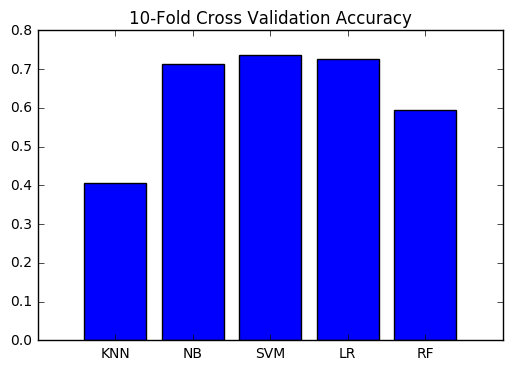

In [68]:
plt.title('10-Fold Cross Validation Accuracy')
plt.bar(range(len(modelsCV)), modelsCV.values(), align='center')
plt.xticks(range(len(modelsCV)), modelsCV.keys())
plt.show()

## Train/Test vs 10-Fold Cross Validation Accuracy

# ![alt text](http://i.imgur.com/fdxFFgv.png "Train/Test vs 10-Fold Cross Validation Accuracy")

# Συσταδοποίηση μέσω Πινάκων - Μασκών Συνάφειας

In [69]:
# Δημιουργία αντιγράφου από το dataset
map_df = df.copy()

# Μέγεθος dataset
print(map_df.shape)

# Υπολογισμός πλήθους instances το 80% του αρχικού
a = int(map_df.shape[0]*.8)

# Τυχαία επιλογή από a id's για να αποτελέσουν το training set
index_list = np.random.choice(df.index.values, a, replace=False)

# Δημιουργία του training dataframe 
map_df_train = map_df.ix[index_list]

# Δημιουργία του test dataframe
map_df_test = map_df.drop(map_df.index[[index_list]])
print(map_df_train.shape,map_df_test.shape)

# Ορισμός των Χ καi y
X_map_train = map_df_train['review/text']
y_map_train = map_df_train.real_category_num

# Δημιουργία του διανυσματικού πίνακα
X_map_train_dtm = vect.fit_transform(X_map_train)

(17960, 6)
(14368, 6) (3592, 6)


In [70]:
# Λίστα που αποθηκεύει τα μοντέλα ταξινόμησης
map_models = []
mdl = LogisticRegression()
map_models.append(mdl)
mdl = RandomForestClassifier()
map_models.append(mdl)
mdl = MultinomialNB()
map_models.append(mdl)
mdl = KNeighborsClassifier(n_neighbors=1)
map_models.append(mdl)
mdl = svm.SVC(kernel='linear', C=1)
map_models.append(mdl)

# Εκπαίδευση των μοντέλων
for m in map_models:
    m.fit(X_map_train_dtm, y_map_train)

In [71]:
# Αντιστοίχιση των labels με αριθμούς (id's)
inv_map = {v: k for k, v in tempDict.iteritems()}
inv_map

{0: 'Alternative Rock',
 1: 'Christian',
 2: 'Classical',
 3: 'R&B',
 4: 'Country',
 5: "Children's Music",
 6: 'Jazz',
 7: 'Metal',
 8: 'Special Interest',
 9: 'Pop',
 10: 'New Age',
 11: 'Dance & Electronic',
 12: 'Rap & Hip-Hop',
 13: 'World Music',
 14: 'Rock',
 15: 'Blues',
 16: 'Folk',
 17: 'Classic Rock'}

In [72]:
# Λίστα με τα id's των labels
size = sorted(tempDict.values())
# Λίστες που κρατάνε τα ενδιάμεσα αποτελέσματα των αποδόσεων και άλλων δεδομένων
acc_list = []
as_list = []
dfs = []
# Αρχικός βρόγχος που διαπερνά όλα τα μοντέλα ταξινόμησης
# Για κάθε μοντέλο
for m in map_models:
    # Dictionary που κρατά τις αποδόσεις των μοντέλων
    acc = {}
    # Αρχικοποίηση του πίνακα με τιμές 0
    A = np.zeros(shape=(len(size), len(size)))
    print(str(m)+'\n')
    # Για κάθε label
    for i in size:
        # Λεκτικό label
        label = inv_map[i]
        print('Label: ',label,' - ', i)
        # Φιλτράρισμα του dataset μόνο για το τρέχων label
        XX = map_df_test[map_df_test.real_category_num == i]['review/text']
        yy = map_df_test[map_df_test.real_category_num == i]['real_category_num']
        XX_dtm = vect.transform(XX)
        # Διαδικασία πρόβλεψης του τρέχοντος μοντέλου
        cvpredicted = m.predict(XX_dtm)
        print(XX_dtm.shape)
        # Υπολογισμός ποσοστού απόδοσης σωστών προβλέψεων
        ac = metrics.accuracy_score(yy, cvpredicted)
        print("Accuracy: %0.2f %%" % (ac * 100))
        acc[label] = ac
        y_mis = np.asarray(yy)
        # Υπολογισμός των λανθασμένα ταξινομημένων reviews (κρατάει τα id's το misclassified)
        misclassified = np.where(y_mis != cvpredicted)
        print('Misclassified entries: ',len(misclassified[0]))
        # Υπολογισμός των σωσττά ταξινομημένων reviews (κρατάει τα id's το classifed)
        classified = np.where(y_mis == cvpredicted)
        print('Well-classified entries: ',len(classified[0]))
        # Dataframe με τα misclassified reviews 
        misclassified_df = df.ix[misclassified[0]]
        # Δημιουργία λίστας με την λανθασμένη επιλογή label
        misList = []
        for d, value in enumerate(cvpredicted.tolist()):
            if value != i:
                misList.append(value)
        # Προσθήκη στήλης με την λανθασμένη πρόβλεψη του κάθε review
        misclassified_df['mispred'] = misList
        # Ο πίνακα res αποθηκεύει για κάθε label πόσα reviews συγκέντρωσε και το διαιρώ με το πλήθος των
        # misclassified για να έχω το τελικό ποσοστό σε κάθε κατηγορία
        res = misclassified_df.mispred.value_counts()/len(misclassified[0])
        # Ο παραπάνω πίνακας  αφορά ένα μόνο label (το τρέχων) οπότε καταχωρείται η γραμμή στον πίνακα
        # αποτελεσμάτων Α
        A[i] = res.as_matrix(size)
        # Το στοιχείο της διαγωνίου παίρνει την τιμή 0
        A[i][i] = 0
        print('----------------------------------------------------------------------------------')
        print
        asaf = pd.DataFrame(data=A, index=size, columns=size)
        nd = asaf.fillna(0)
    # Αποθηκεύονται τα δεδομένα πριν περάσουμε στο επόμενο μοντέλο
    dfs.append(nd)
    acc_list.append(acc)
    as_list.append(A)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Label:  Alternative Rock  -  0
(194, 290796)
Accuracy: 62.37 %
Misclassified entries:  73
Well-classified entries:  121
----------------------------------------------------------------------------------
Label:  Christian  -  1
(218, 290796)
Accuracy: 79.82 %
Misclassified entries:  44
Well-classified entries:  174
----------------------------------------------------------------------------------
Label:  Classical  -  2
(194, 290796)
Accuracy: 79.90 %
Misclassified entries:  39
Well-classified entries:  155
----------------------------------------------------------------------------------
Label:  R&B  -  3
(192, 290796)
Accuracy: 66.15 %
Misclassified entries:  65
Well-classified entries:  127
--------------------------------

In [168]:
acc_list[0]
inv_map
for o in size:
    print(o,'\t',inv_map[o],'\t',acc_list[0][inv_map[o]])

0 	 Alternative Rock 	 0.623711340206
1 	 Christian 	 0.798165137615
2 	 Classical 	 0.798969072165
3 	 R&B 	 0.661458333333
4 	 Country 	 0.684729064039
5 	 Children's Music 	 0.899122807018
6 	 Jazz 	 0.688995215311
7 	 Metal 	 0.777173913043
8 	 Special Interest 	 0.828571428571
9 	 Pop 	 0.36170212766
10 	 New Age 	 0.772020725389
11 	 Dance & Electronic 	 0.836734693878
12 	 Rap & Hip-Hop 	 0.858585858586
13 	 World Music 	 0.405128205128
14 	 Rock 	 0.502463054187
15 	 Blues 	 0.722772277228
16 	 Folk 	 0.821621621622
17 	 Classic Rock 	 0.6


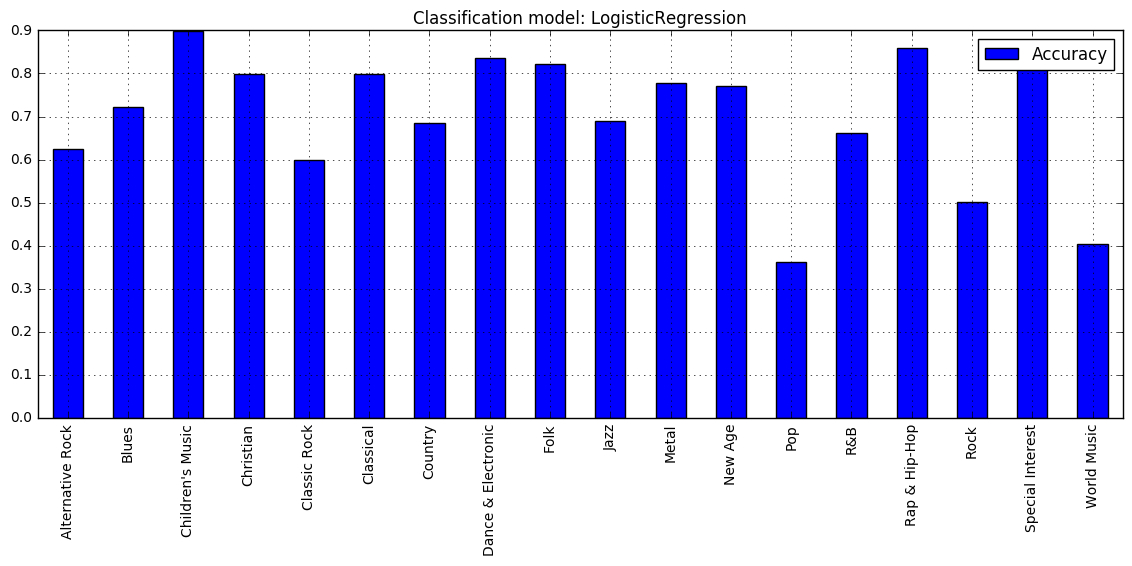

In [73]:
pd.Series(acc_list[0]).plot(kind='bar', ax=None, figsize=(14,5), use_index=True, title='Classification model: ' + str(str(map_models[0])[0:str(map_models[0]).find("(")]) , grid=True, legend=True, style=None, logy=False, label='Accuracy')

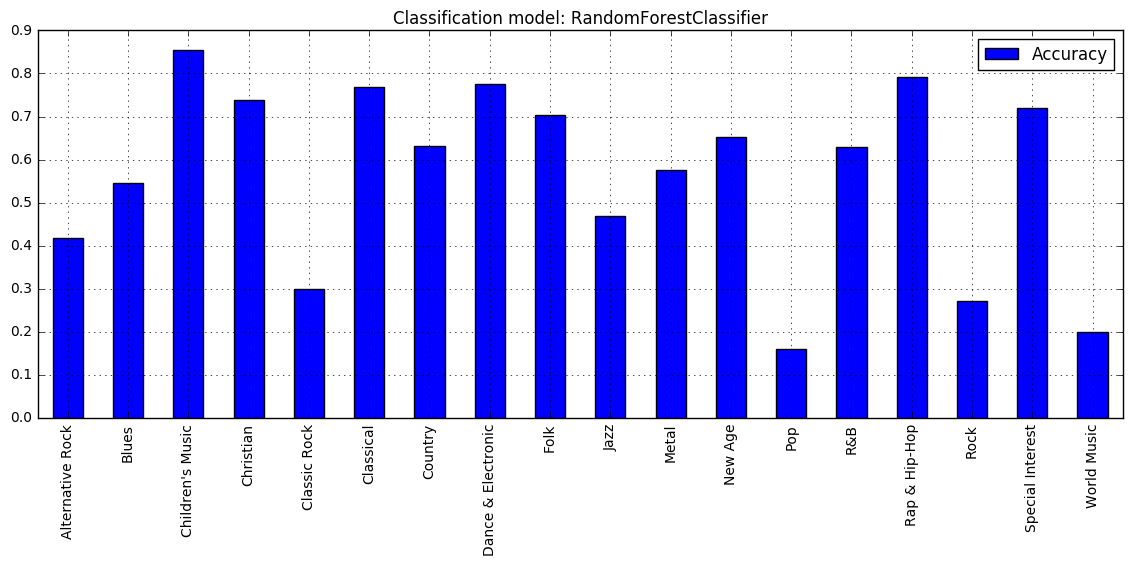

In [74]:
pd.Series(acc_list[1]).plot(kind='bar', ax=None, figsize=(14,5), use_index=True, title='Classification model: ' + str(str(map_models[1])[0:str(map_models[1]).find("(")]) , grid=True, legend=True, style=None, logy=False, label='Accuracy')

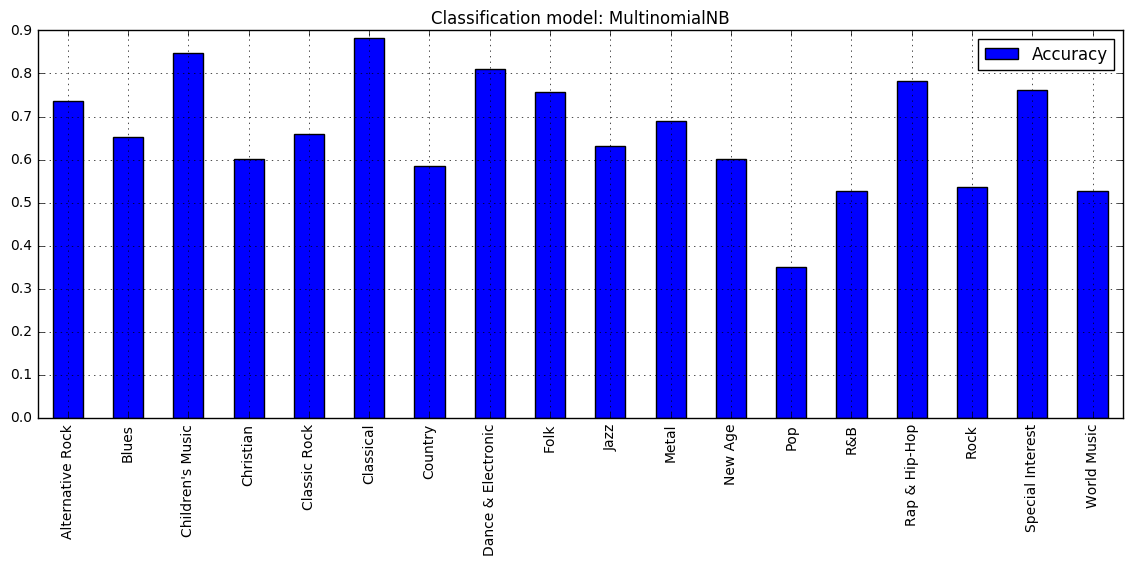

In [75]:
pd.Series(acc_list[2]).plot(kind='bar', ax=None, figsize=(14,5), use_index=True, title='Classification model: ' + str(str(map_models[2])[0:str(map_models[2]).find("(")]) , grid=True, legend=True, style=None, logy=False, label='Accuracy')

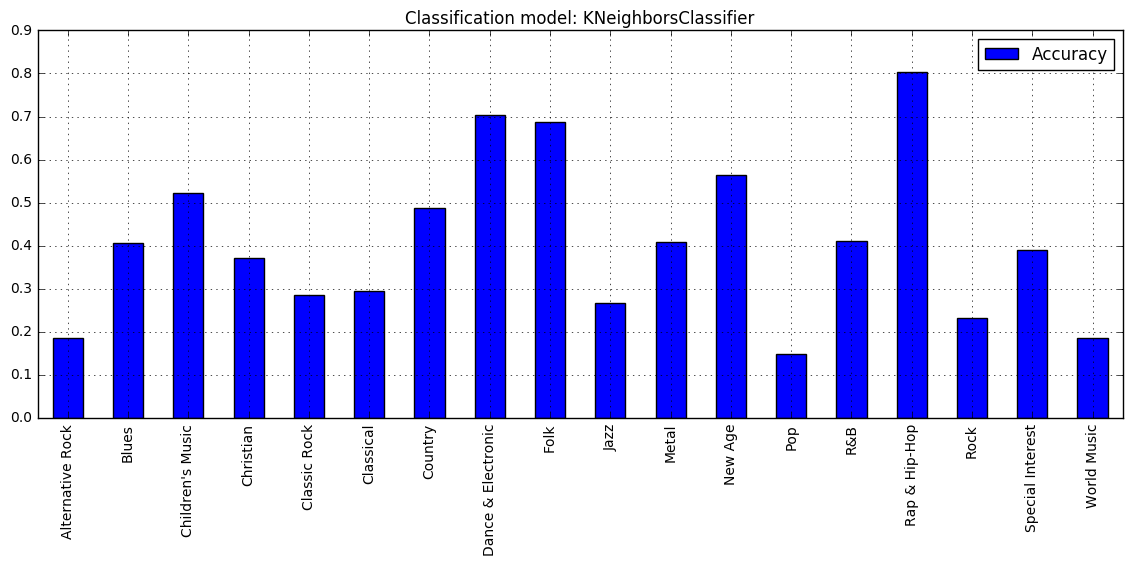

In [76]:
pd.Series(acc_list[3]).plot(kind='bar', ax=None, figsize=(14,5), use_index=True, title='Classification model: ' + str(str(map_models[3])[0:str(map_models[3]).find("(")]) , grid=True, legend=True, style=None, logy=False, label='Accuracy')

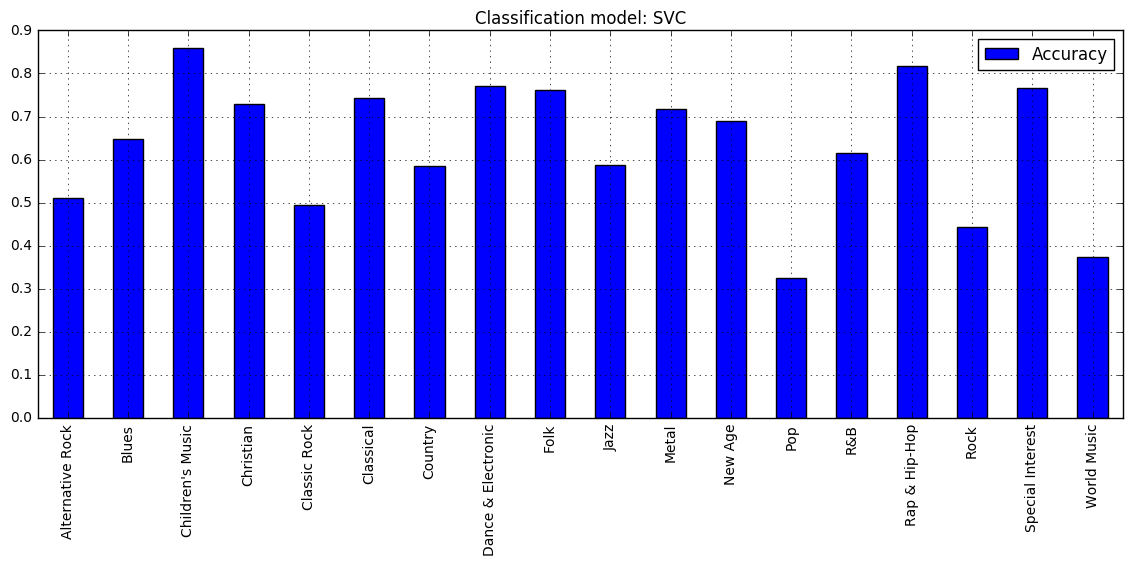

In [77]:
pd.Series(acc_list[4]).plot(kind='bar', ax=None, figsize=(14,5), use_index=True, title='Classification model: ' + str(str(map_models[4])[0:str(map_models[4]).find("(")]) , grid=True, legend=True, style=None, logy=False, label='Accuracy')

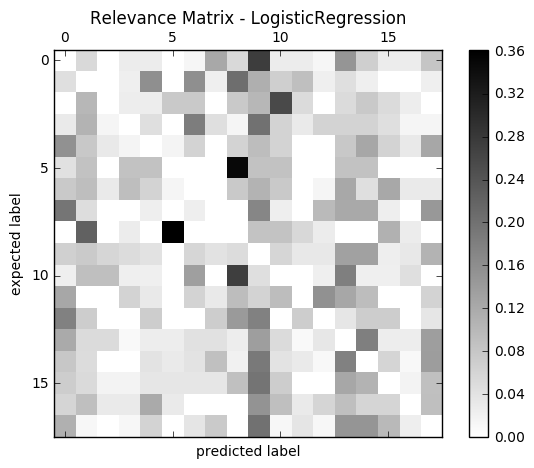

In [78]:
plt.figure(num=None, figsize=(7, 5), dpi=80)
plt.matshow(as_list[0], cmap=plt.cm.binary, interpolation='nearest', fignum=0)
plt.title('Relevance Matrix - ' + str(str(map_models[0])[0:str(map_models[0]).find("(")]))
plt.colorbar()
plt.ylabel('expected label')
plt.xlabel('predicted label')

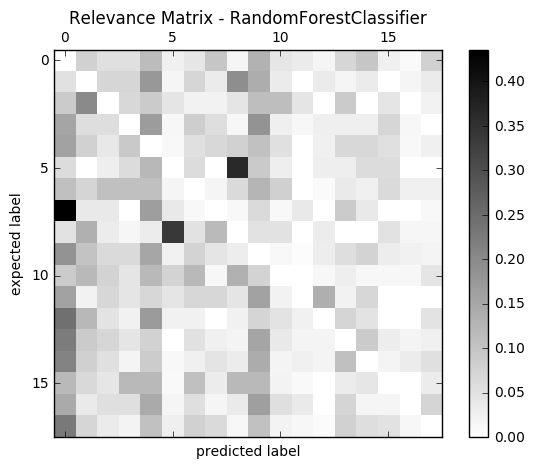

In [79]:
plt.figure(num=None, figsize=(7, 5), dpi=80)
plt.matshow(as_list[1], cmap=plt.cm.binary, interpolation='nearest', fignum=0)
plt.title('Relevance Matrix - ' + str(str(map_models[1])[0:str(map_models[1]).find("(")]))
plt.colorbar()
plt.ylabel('expected label')
plt.xlabel('predicted label')

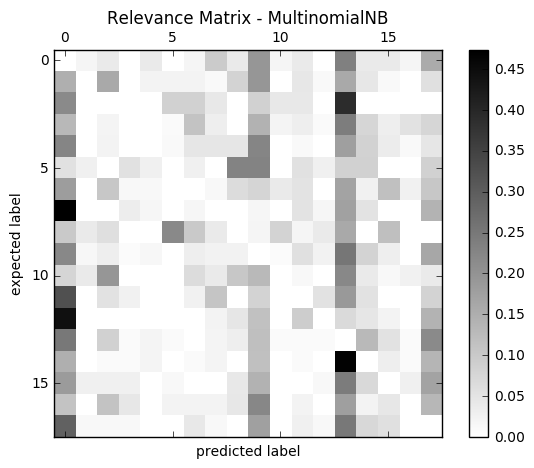

In [80]:
plt.figure(num=None, figsize=(7, 5), dpi=80)
plt.matshow(as_list[2], cmap=plt.cm.binary, interpolation='nearest', fignum=0)
plt.title('Relevance Matrix - ' + str(str(map_models[2])[0:str(map_models[2]).find("(")]))
plt.colorbar()
plt.ylabel('expected label')
plt.xlabel('predicted label')

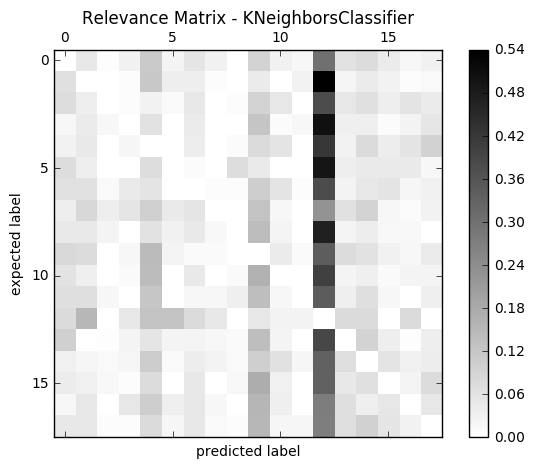

In [81]:
plt.figure(num=None, figsize=(7, 5), dpi=80)
plt.matshow(as_list[3], cmap=plt.cm.binary, interpolation='nearest', fignum=0)
plt.title('Relevance Matrix - ' + str(str(map_models[3])[0:str(map_models[3]).find("(")]))
plt.colorbar()
plt.ylabel('expected label')
plt.xlabel('predicted label')

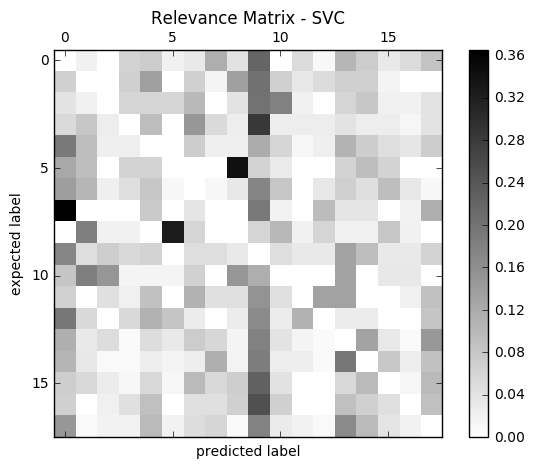

In [82]:
plt.figure(num=None, figsize=(7, 5), dpi=80)
plt.matshow(as_list[4], cmap=plt.cm.binary, interpolation='nearest', fignum=0)
plt.title('Relevance Matrix - ' + str(str(map_models[4])[0:str(map_models[4]).find("(")]))
plt.colorbar()
plt.ylabel('expected label')
plt.xlabel('predicted label')

In [100]:
# try K=1 through K=25 and record testing accuracy
k_range = list(range(1, 26))
knnscores = []
for k in k_range:
    knnn = KNeighborsClassifier(n_neighbors=k)
    knnn.fit(X_train_dtm, y_train)
    y_predd = knnn.predict(X_test_dtm)
    knnscores.append(metrics.accuracy_score(y_test, y_predd))

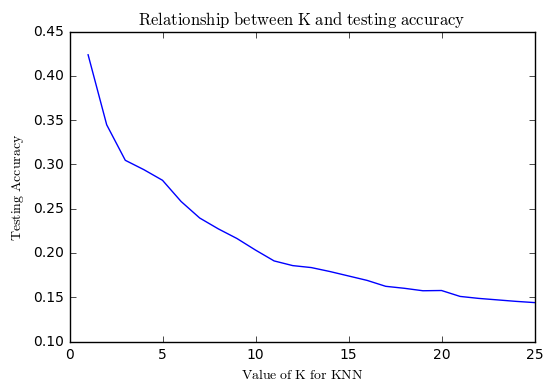

In [105]:
# plot the relationship between K and testing accuracy
plt.plot(k_range, knnscores)
plt.title(r"$\mathrm{Relationship\ between\ K\ and\ testing\ accuracy}$")
plt.xlabel(r"$\mathrm{Value\ of\ K\ for\ KNN}$")
plt.ylabel(r"$\mathrm{Testing\ Accuracy}$")

In [108]:
import cPickle
with open('sms_spam_detector.pkl', 'wb') as fout:
    cPickle.dump(knnn, fout)

In [109]:
svm_detector_reloaded = cPickle.load(open('sms_spam_detector.pkl'))